In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [20]:
# Cargar el conjunto de datos
df = pd.read_csv('../datos_exportados_clean.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])


In [21]:
# Filtrar el dataset para la latitud y longitud específica
lat = 22.625
lon = -107.125
df_filtered = df[(df['Latitud'] == lat) & (df['Longitud'] == lon)]
df_filtered['Fecha'] = pd.to_datetime(df_filtered['Fecha'])

In [22]:
df_filtered2 = df_filtered.copy()

In [23]:
# Crear las series retardadas
n_pasados = 36
n_futuros = 6
for i in range(1, n_pasados + 1):
    df_filtered[f'SST_lag_{i}'] = df_filtered['SST'].shift(i)


In [24]:
# Eliminar las filas con valores NaN resultantes del desplazamiento
df_filtered.dropna(inplace=True)

In [25]:
# Normalizar solo la columna 'SST'
scaler = MinMaxScaler()
df_filtered['SST'] = scaler.fit_transform(df_filtered[['SST']])

In [26]:
# Preparar los datos para la LSTM
def crear_secuencia(datos, n_pasados, n_futuros):
    X, y = [], []
    for i in range(n_pasados, len(datos) - n_futuros + 1):
        X.append(datos[i-n_pasados:i])
        y.append(datos[i+n_futuros-1])
    return np.array(X), np.array(y)

X, y = crear_secuencia(df_filtered['SST'].values, n_pasados, n_futuros)

# Reshape para la LSTM [muestras, pasos de tiempo, características]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [27]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo con el 100% de los datos
model.fit(X, y, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
14/14 - 2s - loss: 0.1948 - 2s/epoch - 159ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0666 - 159ms/epoch - 11ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0579 - 197ms/epoch - 14ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0513 - 188ms/epoch - 13ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0455 - 176ms/epoch - 13ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0391 - 174ms/epoch - 12ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0310 - 204ms/epoch - 15ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0206 - 187ms/epoch - 13ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0108 - 227ms/epoch - 16ms/step
Epoch 10/100
14/14 - 0s - loss: 0.0094 - 191ms/epoch - 14ms/step
Epoch 11/100
14/14 - 0s - loss: 0.0087 - 190ms/epoch - 14ms/step
Epoch 12/100
14/14 - 0s - loss: 0.0087 - 190ms/epoch - 14ms/step
Epoch 13/100
14/14 - 0s - loss: 0.0084 - 159ms/epoch - 11ms/step
Epoch 14/100
14/14 - 0s - loss: 0.0082 - 165ms/epoch - 12ms/step
Epoch 15/100
14/14 - 0s - loss: 0.0080 - 159ms/epoch - 11ms/step
Epoch 16/100
14/14 - 0s - loss: 0.00

In [28]:
# Preparar los datos para hacer predicciones de 2010 a 2020
fecha_inicio = pd.to_datetime('2010-01-01')
fecha_fin = pd.to_datetime('2020-12-31')
df_pred = df_filtered[(df_filtered['Fecha'] >= fecha_inicio) & (df_filtered['Fecha'] <= fecha_fin)]



In [29]:
# Crear las series retardadas para la predicción
for i in range(1, n_pasados + 1):
    df_pred[f'SST_lag_{i}'] = df_pred['SST'].shift(i)

In [30]:
# Eliminar filas con valores NaN
df_pred.dropna(inplace=True)

In [31]:
# Hacer predicciones
X_pred = np.array([df_pred[f'SST_lag_{i}'].values for i in range(1, n_pasados + 1)]).T
X_pred = X_pred.reshape((X_pred.shape[0], X_pred.shape[1], 1))
y_pred = model.predict(X_pred)
y_pred = scaler.inverse_transform(y_pred)


3/3 [==============================] - 0s 0s/step


In [32]:
fecha_inicio = pd.to_datetime('2013-01-01')
fecha_fin = pd.to_datetime('2020-12-31')

In [33]:
df_reales = df_filtered2[(df_filtered2['Fecha'] >= fecha_inicio) & (df_filtered2['Fecha'] <= fecha_fin)]

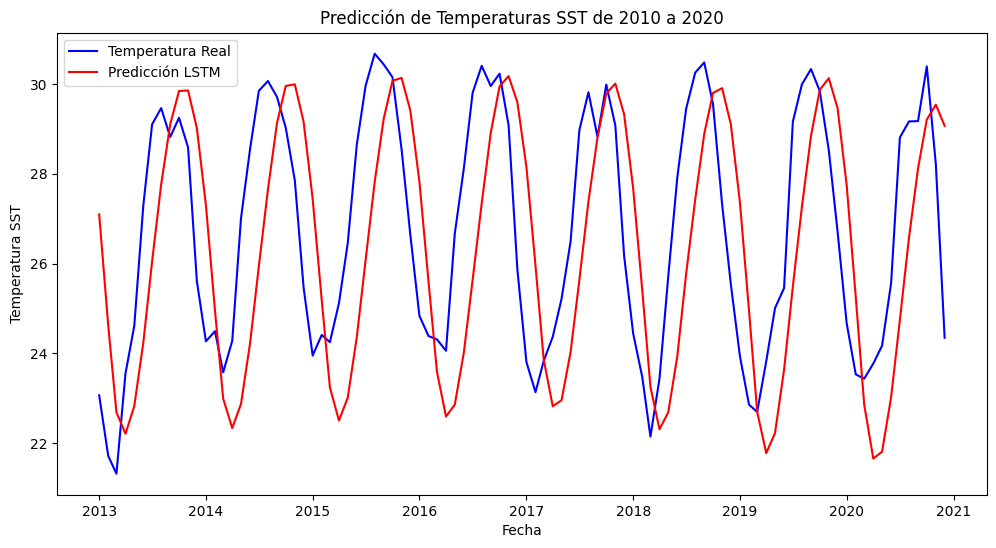

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(df_reales['Fecha'], df_reales['SST'], label='Temperatura Real', color='blue')
plt.plot(df_reales['Fecha'], y_pred[::-1], label='Predicción LSTM', color='red')
plt.xlabel('Fecha')
plt.ylabel('Temperatura SST')
plt.title('Predicción de Temperaturas SST de 2010 a 2020')
plt.legend()
plt.show()